## Loading Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
import math
import re
import random
import statsmodels.api as sm
import torch.optim as optim
from math import sqrt
from matplotlib import pyplot
from datetime import datetime, timedelta
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, matthews_corrcoef
import torch.nn as nn
import torch
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
from skorch import NeuralNetBinaryClassifier
warnings.filterwarnings('ignore')

In [ ]:
pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Fixed seeds to ensure reproducibility
SEED_VALUE = 0
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

## Reading Data (No need to run as we already have pre-processed data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
# reading extraced data from MIMIC-IV database
data = pd.read_csv('filtered_patients_dataset_v2.csv')

## Proprocessing Data

### Checking the Correlation between each variables
* In this part, we will remove some columns that are not wanted for sure like subject_id and dod
* Furthermore, we will label encode several columns such as 'gender' and 'weaning_class' because values of these 2 columns are in string, so that we can retrieve the correlation.
* Main focus will be column 'weaning_class' as it is the label we would like to predict

#### Binary Encoding of the 2 columns
* Mapping gender female as 0 and male as 1
* Mapping class Weaning Fail (WF) as 0 and Weaning Success (WS) as 1

In [ ]:
# columns to be dropped
col_to_drop = ['subject_id', 'dod', 'weaning_start_time']

# removing unwanted columns
data = data.drop(col_to_drop, axis = 1)

In [ ]:
# label encoding columns 'gender' and 'weaning_class'
data['gender'] = data['gender'].map({'F': 0, 'M': 1})
data['weaning_class'] = data['weaning_class'].map({'WF': 0, 'WS': 1})

In [ ]:
# check if data consist of missing values
missing_values = data.isna()
# count the missing values in each column
missing_count = missing_values.sum()

print("Missing Values Count:")
print(missing_count)

Missing Values Count:
avg_ventilation_duration_in_days    0
arterial_o2_pressure                0
arterial_co2_pressure               0
arterial_base_excess                0
inspired_o2_fraction                0
WBC                                 0
platelet                            0
Hemoglobin                          0
Heart_rate                          0
Respiratory_Rate                    0
Arterial_BP_mean                    0
Temperature_Celsius                 0
Creatinine                          0
age                                 0
gender                              0
PEEP_Level                          0
SpO2                                0
Anion_gap                           0
Urine_output                        0
weaning_class                       0
dtype: int64


From the output above, it can be seen that there is no missing values in the dataset

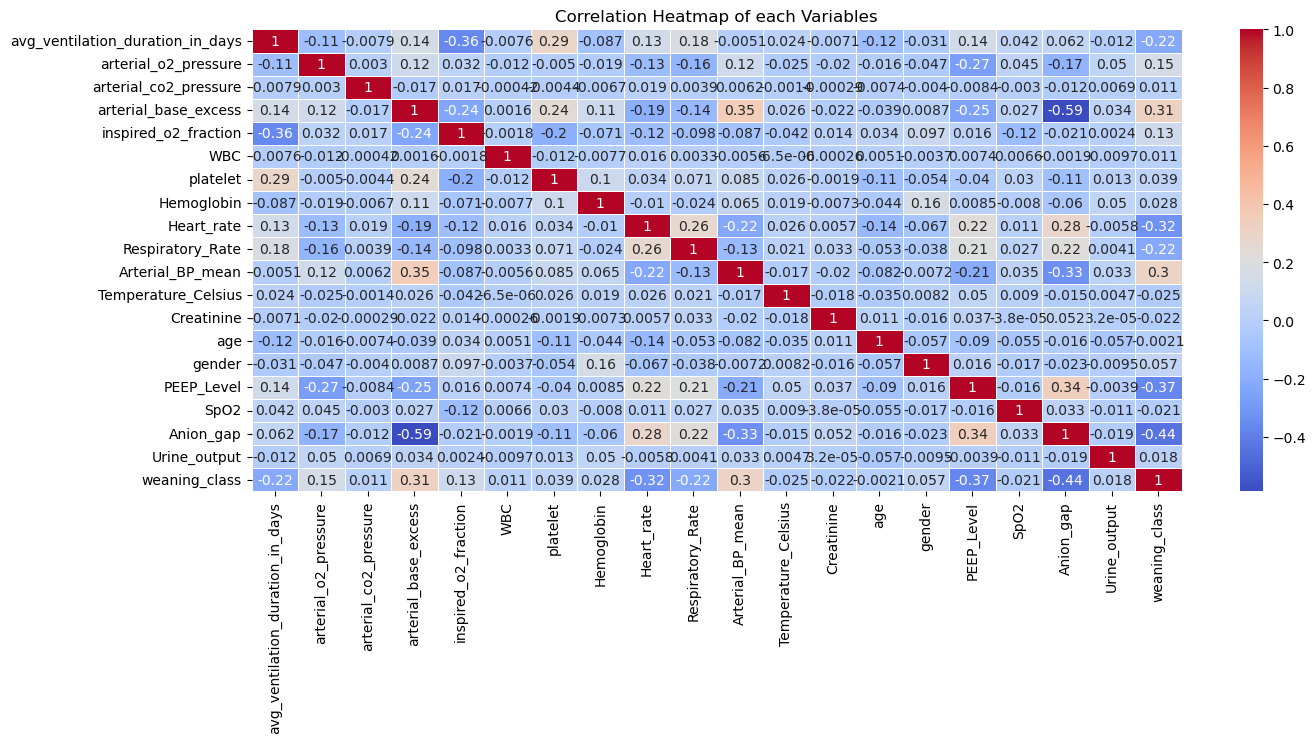

In [ ]:
# check the correlation between each variables
corr_matrix = data.corr()

# plotting heatmap to have a clearer observation
plt.figure(figsize=(15, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of each Variables')
plt.savefig('correlation_heatmap.png')
plt.show()

From the heatmap, it can be observed that the <b>'weaning_class'</b> has stronger correlation with variables <b>'arterial_base_excess'</b>, and <b>'Arterial_BP_mean'</b> as compared to other variables. However, it does not indicate that other variables are not important as correlation does not imply causation. Moreover, there might be some strong correlationgs between variables.

## Data Exploration

In [ ]:
# Look for statistics summary of each variables
print(data['weaning_class'].value_counts())
data.describe()

1    3930
0    1591
Name: weaning_class, dtype: int64


,avg_ventilation_duration_in_days,arterial_o2_pressure,arterial_co2_pressure,arterial_base_excess,inspired_o2_fraction,WBC,platelet,Hemoglobin,Heart_rate,Respiratory_Rate,Arterial_BP_mean,Temperature_Celsius,Creatinine,age,gender,PEEP_Level,SpO2,Anion_gap,Urine_output,weaning_class
count,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.00000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5521.00000,5521.000000
mean,3.511039,109.946961,475.305562,-2.995491,71.945505,389.076203,178.596301,9.260198,102.03697,26.902146,57.322394,37.541654,187.864684,65.586850,0.592465,7.456549,85.520876,14.609737,575.51594,0.711828
std,5.564186,42.612651,19029.697750,5.588078,26.598187,19030.809571,118.894935,1.765189,21.66290,9.346271,15.002430,2.072351,13458.260371,14.821746,0.491420,2.764447,2.813107,5.747139,308.81005,0.452953
min,0.000103,16.000000,16.000000,-33.000000,6.000000,0.100000,5.000000,2.200000,46.00000,12.000000,-38.000000,31.500000,0.200000,18.000000,0.000000,-3.600000,4.000000,3.000000,5.00000,0.000000
25%,0.320139,83.000000,41.000000,-4.000000,50.000000,10.100000,108.000000,8.100000,87.00000,22.000000,54.000000,37.541654,0.700000,57.000000,0.000000,5.200000,85.000000,11.000000,575.51594,0.000000
50%,1.207639,108.000000,46.000000,-2.995491,70.000000,13.800000,153.000000,9.200000,98.00000,26.000000,58.000000,37.541654,1.000000,67.000000,1.000000,7.456549,85.000000,13.000000,575.51594,1.000000
75%,4.596759,122.000000,56.000000,0.000000,100.000000,19.200000,213.000000,10.300000,113.00000,30.000000,65.000000,37.541654,1.600000,76.000000,1.000000,7.456549,85.000000,16.000000,575.51594,1.000000
max,99.572222,495.000000,999999.000000,26.000000,100.000000,999999.000000,1992.000000,17.200000,459.00000,280.000000,165.000000,101.100000,999999.000000,91.000000,1.000000,33.000000,100.000000,59.000000,6670.00000,1.000000


In [ ]:
# checking the mean of each variables when it is categorised as 0 or 1 in weaning_class
data.groupby('weaning_class').mean()

,avg_ventilation_duration_in_days,arterial_o2_pressure,arterial_co2_pressure,arterial_base_excess,inspired_o2_fraction,WBC,platelet,Hemoglobin,Heart_rate,Respiratory_Rate,Arterial_BP_mean,Temperature_Celsius,Creatinine,age,gender,PEEP_Level,SpO2,Anion_gap,Urine_output
weaning_class,,,,,,,,,,,,,,,,,,,
0,5.400869,99.907156,136.725366,-5.754553,66.714439,45.935958,171.299400,9.183812,112.856764,30.066823,50.262273,37.623057,643.869688,65.634821,0.548083,9.050197,85.611594,18.604236,566.726879
1,2.745970,114.011422,612.374541,-1.878527,74.063221,527.991248,181.550339,9.291122,97.656743,25.620976,60.180576,37.508699,3.258078,65.567430,0.610433,6.811384,85.484151,12.992626,579.074057


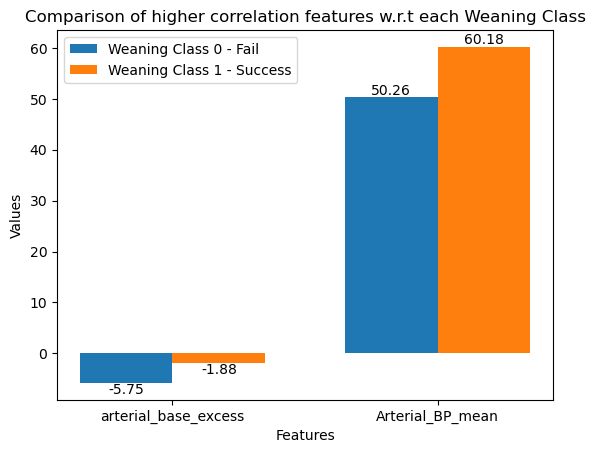

In [ ]:
# checking the mean of each variables when it is categorised as 0 or 1 in weaning_class
mean_class = data.groupby('weaning_class').mean()

# display a new df with columns that are strongly correlated with target variable
strong_corr_col = ['arterial_base_excess', 'Arterial_BP_mean']
mean_class_selected = mean_class[strong_corr_col]

# setting bar width
bar_width = 0.35
x = np.arange(len(strong_corr_col))

# create figure and axis
fig, ax = plt.subplots()

# create bars for each weaning class
for i in mean_class_selected.index.values:
    if i == 0:
        bars = ax.bar(x + i * bar_width, mean_class_selected.values[i], width = bar_width,
                      label = f'Weaning Class {i} - Fail')
    else:
        bars = ax.bar(x + i * bar_width, mean_class_selected.values[i], width=bar_width,
                      label = f'Weaning Class {i} - Success')

    # adding respective values at top of the bar
    for bar, value in zip(bars, mean_class_selected.values[i]):
        if value < 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', ha='center', va='top')
        else:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom')

# setting labels and titles
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(strong_corr_col)
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Comparison of higher correlation features w.r.t each Weaning Class')

# adding legend
ax.legend()

# Show the plot
plt.savefig('mean_comparison_class.png')
plt.show()

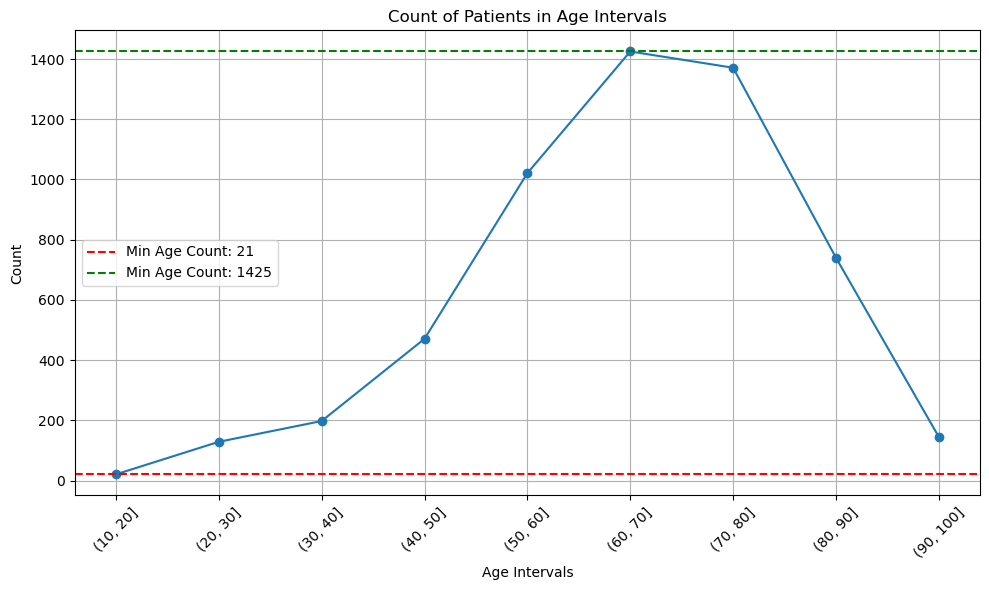

In [ ]:
# Define the age intervals
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create age bins and count the number of occurrences
age_intervals = pd.cut(data['age'], bins=bins)
age_counts = age_intervals.value_counts().sort_index()

# Convert age intervals to string in order to make plot
age_intervals_str = [str(interval) for interval in age_counts.index]

# Extract the counts
counts = age_counts.values

min_age_count = counts.min()
max_age_count = counts.max()

# Create a scatter plot with line
plt.figure(figsize=(10, 6))
plt.plot(age_intervals_str, counts, '-o')
plt.xlabel('Age Intervals')
plt.ylabel('Count')
plt.title('Count of Patients in Age Intervals')
plt.xticks(rotation=45)
plt.grid(True)

# horizontal dashed line for the minimum count of ages
plt.axhline(y=min_age_count, color='red', linestyle='--', label=f'Min Age Count: {min_age_count}')
plt.axhline(y=max_age_count, color='green', linestyle='--', label=f'Min Age Count: {max_age_count}')

plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig('patient_age_count.png')
plt.show()

### Save preprocessed data

In [ ]:
# save the preprocessed data
data.to_csv('pre_processed_data.csv', index = False)

## Feature engineering (If we have pre-processed data already, we can start here)

In [ ]:
data = pd.read_csv('pre_processed_data.csv')
data

,avg_ventilation_duration_in_days,arterial_o2_pressure,arterial_co2_pressure,arterial_base_excess,inspired_o2_fraction,WBC,platelet,Hemoglobin,Heart_rate,Respiratory_Rate,Arterial_BP_mean,Temperature_Celsius,Creatinine,age,gender,PEEP_Level,SpO2,Anion_gap,Urine_output,weaning_class
0,7.336111,100.000000,51.000000,-1.000000,50.0,15.0,209.0,8.7,111.0,34.0,57.322394,37.541654,1.0,74,0,7.456549,85.0,15.0,575.51594,1
1,0.975000,20.000000,75.000000,-18.000000,100.0,7.5,68.0,5.7,132.0,32.0,59.000000,37.541654,2.3,59,0,6.000000,85.0,32.0,575.51594,0
2,0.668750,114.000000,37.000000,-20.000000,40.0,28.9,226.0,7.8,126.0,21.0,45.000000,37.541654,2.5,69,0,7.000000,85.0,48.0,575.51594,0
3,22.254861,36.000000,49.000000,0.000000,40.0,24.1,423.0,7.8,87.0,37.0,57.322394,37.541654,1.8,77,1,7.456549,85.0,16.0,575.51594,0
4,3.194444,109.946961,475.305562,-2.995491,40.0,7.8,110.0,10.1,77.0,21.0,60.000000,37.541654,1.1,72,1,5.000000,85.0,12.0,575.51594,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5516,0.304167,94.000000,48.000000,0.000000,50.0,16.9,281.0,10.8,111.0,19.0,54.000000,37.541654,0.5,69,0,7.456549,85.0,12.0,1600.00000,1
5517,6.563889,109.946961,475.305562,-2.995491,35.0,9.9,316.0,9.0,84.0,27.0,61.000000,37.541654,0.6,88,0,7.456549,88.0,10.0,575.51594,0
5518,0.277083,315.000000,36.000000,0.000000,40.0,16.3,176.0,12.4,74.0,25.0,78.000000,37.541654,0.8,65,1,5.000000,88.0,14.0,150.00000,1
5519,0.156250,99.000000,57.000000,-4.000000,100.0,13.9,181.0,11.4,100.0,21.0,64.000000,38.700000,0.7,54,1,7.456549,85.0,13.0,650.00000,1


### get features and labels

In [ ]:
# X will be the variables column and y will be the predict variable (target)
X = data.loc[:, data.columns != 'weaning_class']
y = data.loc[:, data.columns == 'weaning_class']

### splitting data into training and test

In [ ]:
# splitting data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
columns = X_train.columns

### upsample to balance the distribution of dataset

In [ ]:
# First, merge X_train and y_train
merged_train = pd.concat([X_train, y_train], axis=1)

# Next, using the method above, filter and oversample the merged DataFrame
data_0 = merged_train[merged_train['weaning_class'] == 0]
data_1 = merged_train[merged_train['weaning_class'] == 1]

upsampled_0 = data_0.sample(n=len(data_1), replace=True, random_state=SEED_VALUE)
balanced_train = pd.concat([upsampled_0, data_1], ignore_index=True)
balanced_train = balanced_train.sample(frac=1, random_state=SEED_VALUE, ignore_index=True)

# Finally, split the merged DataFrame back into X and y
balanced_X_train = balanced_train.drop(columns='weaning_class')
balanced_y_train = balanced_train[['weaning_class']]

balanced_y_train[:]

,weaning_class
0,1
1,1
2,0
3,0
4,0
...,...
7043,1
7044,0
7045,0
7046,0


### Recursive Feature Elimination
* Select features by recursively considering smaller and smaller sets of features
* It helps to select the important features of the dataset

In [ ]:
data_vars = data.columns.values.tolist()

# target = ['weaning_class']
# X = [i for i in data_vars if i not in target]

logreg = LogisticRegression()
rfe = RFE(estimator = logreg, n_features_to_select = 12)
rfe = rfe.fit(X, y.values.ravel())

print(rfe.support_)
print(rfe.ranking_)

[ True False False  True  True False False False  True  True  True  True
  True False  True  True  True  True False]
[1 4 6 1 1 8 5 2 1 1 1 1 1 3 1 1 1 1 7]


### RFE has helped to select the 12 features

In [ ]:
cols = [balanced_X_train.columns[0], balanced_X_train.columns[3], balanced_X_train.columns[4], balanced_X_train.columns[8], balanced_X_train.columns[9], balanced_X_train.columns[10],
     balanced_X_train.columns[11], balanced_X_train.columns[12], balanced_X_train.columns[14], balanced_X_train.columns[15], balanced_X_train.columns[16], balanced_X_train.columns[17]]

X_train = balanced_X_train[cols]
y_train = balanced_y_train['weaning_class']
X_test = X_test[cols]
X_train

,avg_ventilation_duration_in_days,arterial_base_excess,inspired_o2_fraction,Heart_rate,Respiratory_Rate,Arterial_BP_mean,Temperature_Celsius,Creatinine,gender,PEEP_Level,SpO2,Anion_gap
0,0.354167,-2.000000,40.0,95.0,30.0,63.000000,37.541654,0.6,1,5.200000,88.000000,12.0
1,0.350000,-8.000000,100.0,102.0,22.0,58.000000,37.541654,1.3,0,9.000000,85.000000,11.0
2,0.625694,-7.000000,100.0,125.0,26.0,57.322394,37.541654,2.5,0,10.000000,85.000000,18.0
3,7.256944,-2.995491,40.0,85.0,25.0,57.322394,37.541654,0.7,1,7.456549,90.000000,8.0
4,7.918056,-18.000000,40.0,159.0,44.0,25.000000,37.541654,0.9,0,7.456549,88.000000,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7043,0.285417,-6.000000,100.0,95.0,28.0,60.000000,36.500000,0.7,1,5.000000,85.000000,10.0
7044,10.729861,4.000000,70.0,109.0,22.0,68.000000,37.541654,1.2,1,5.600000,88.000000,16.0
7045,3.504861,-3.000000,100.0,80.0,24.0,62.000000,37.200000,9.3,1,5.300000,85.520876,18.0
7046,1.426389,0.000000,100.0,86.0,40.0,62.000000,37.541654,0.7,1,7.456549,85.000000,12.0


## Baseline Model (Zero-R)

In [ ]:
zero_r = DummyClassifier(strategy="most_frequent")

# define estimator to calaulate multiple metrics
def calculate_metrics(clf, X, y):
  y_pred = clf.predict(X)
  roc_auc = roc_auc_score(y, y_pred)
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  sensitivity = round((float(tp) / float(tp+fn)), 4)
  specificity = round((float(tn) / float(tn+fp)), 4)
  mcc = float(round(matthews_corrcoef(y, y_pred), 4))
  return {'roc_auc': roc_auc, 'sensitivity': sensitivity, 'specificity': specificity, 'mcc': mcc}

# apply 10-fold cross validation
scores_lr = cross_validate(estimator = zero_r, X = X_train, y = y_train, cv = 10, scoring=calculate_metrics)

# print results
print(f"Logistic Regression roc_auc: {round((scores_lr['test_roc_auc'].mean()), 4)}")
print(f"Logistic Regression sensitivity: {round((scores_lr['test_sensitivity'].mean()), 4)}")
print(f"Logistic Regression specificity: {round((scores_lr['test_specificity'].mean()), 4)}")
print(f"Logistic Regression MCC: {round((scores_lr['test_mcc'].mean()), 4)}")

Logistic Regression roc_auc: 0.5
Logistic Regression sensitivity: 0.4
Logistic Regression specificity: 0.6
Logistic Regression MCC: 0.0


## Logistic Regression Model

In [ ]:
lr = LogisticRegression(solver='liblinear')

# define estimator to calaulate multiple metrics
def calculate_metrics(clf, X, y):
  y_pred = clf.predict(X)
  roc_auc = roc_auc_score(y, y_pred)
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  sensitivity = round((float(tp) / float(tp+fn)), 4)
  specificity = round((float(tn) / float(tn+fp)), 4)
  mcc = float(round(matthews_corrcoef(y, y_pred), 4))
  return {'roc_auc': roc_auc, 'sensitivity': sensitivity, 'specificity': specificity, 'mcc': mcc}

# apply 10-fold cross validation
# scores_lr = cross_validate(estimator = lr, X = X_train_scaled, y = y_train, cv = 10, scoring=calculate_metrics)
scores_lr = cross_validate(estimator = lr, X = X_train, y = y_train, cv = 10, scoring=calculate_metrics)

# print results
print(f"Logistic Regression roc_auc: {round((scores_lr['test_roc_auc'].mean()), 4)}")
print(f"Logistic Regression sensitivity: {round((scores_lr['test_sensitivity'].mean()), 4)}")
print(f"Logistic Regression specificity: {round((scores_lr['test_specificity'].mean()), 4)}")
print(f"Logistic Regression MCC: {round((scores_lr['test_mcc'].mean()), 4)}")

Logistic Regression roc_auc: 0.7501
Logistic Regression sensitivity: 0.7923
Logistic Regression specificity: 0.708
Logistic Regression MCC: 0.5026


test our LR on test set

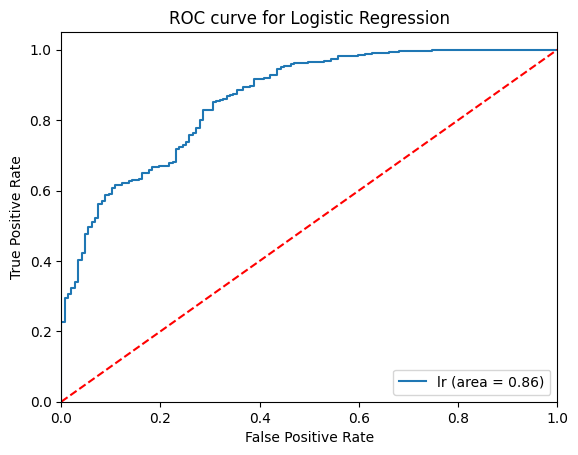

Logistic Regression roc_auc: 0.8599
Logistic Regression sensitivity: 0.7635
Logistic Regression specificity: 0.7347
Logistic Regression MCC: 0.4562


In [ ]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef
lr = LogisticRegression(solver='liblinear')
# Fit and Predict
lr.fit(X_train, y_train)
y_pred_prob = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)

# Calculate ROC metrics
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc1 = auc(fpr1, tpr1)

# Plot ROC curve
plt.plot(fpr1, tpr1, label=f'lr (area = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Calculate Sensitivity, Specificity, MCC
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)

# Print the metrics
print(f'Logistic Regression roc_auc: {roc_auc1:.4f}')
print(f'Logistic Regression sensitivity: {sensitivity:.4f}')
print(f'Logistic Regression specificity: {specificity:.4f}')
print(f'Logistic Regression MCC: {mcc:.4f}')


## KNN model

Normalization

In [ ]:
# use standard scaler to normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

use GridSearchCV to find the best hyperparameters

In [ ]:
knn_model = KNeighborsClassifier()

knn_param_grid = {'n_neighbors': [2, 4, 6, 8, 10],
          'weights': ["uniform", "distance"],
          'metric': ['l1', 'l2']}

# use GridSearchCV with cv=5 to find best hyperparameters
knn_model = GridSearchCV(knn_model, knn_param_grid, cv=10, scoring='roc_auc', n_jobs=-1)
knn_model.fit(X_train_scaled, y_train)

# print the best hyperparameters
knn_best_params = knn_model.best_params_
print(f'knn_best_parameters : {knn_model.best_params_}')

knn_best_parameters : {'metric': 'l1', 'n_neighbors': 10, 'weights': 'distance'}


In [ ]:
# use knn model to train
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='l1')

# define estimator to calaulate multiple metrics
def calculate_metrics(clf, X, y):
  y_pred = clf.predict(X)
  roc_auc = roc_auc_score(y, y_pred)
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  sensitivity = round((float(tp) / float(tp+fn)), 4)
  specificity = round((float(tn) / float(tn+fp)), 4)
  mcc = float(round(matthews_corrcoef(y, y_pred), 4))
  return {'roc_auc': roc_auc, 'sensitivity': sensitivity, 'specificity': specificity, 'mcc': mcc}

# perform 10-fold cross validation
scores_knn = cross_validate(estimator = knn, X = X_train_scaled, y = y_train, cv = 10, scoring=calculate_metrics)

# print results
print('KNN roc_auc: ', round((scores_knn['test_roc_auc'].mean()), 4))
print('KNN sensitivity: ', round((scores_knn['test_sensitivity'].mean()), 4))
print('KNN specificity: ', round((scores_knn['test_specificity'].mean()), 4))
print('KNN MCC: ', round((scores_knn['test_mcc'].mean()), 4))

KNN roc_auc:  0.8946
KNN sensitivity:  0.834
KNN specificity:  0.9552
KNN MCC:  0.7951


test our KNN on test set

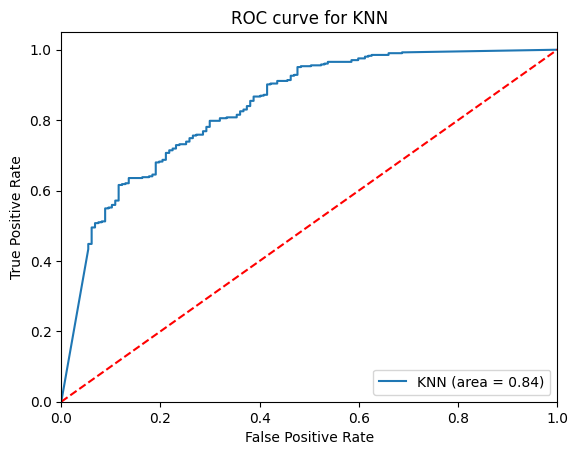

KNN roc_auc: 0.8387
KNN sensitivity: 0.8153
KNN specificity: 0.6395
KNN MCC: 0.4361


In [ ]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef

# Fit and Predict
knn.fit(X_train_scaled, y_train)
y_pred_prob = knn.predict_proba(X_test_scaled)[:, 1]
y_pred = knn.predict(X_test_scaled)

# Calculate ROC metrics
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc2 = auc(fpr2, tpr2)

# Plot ROC curve
plt.plot(fpr2, tpr2, label=f'KNN (area = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for KNN')
plt.legend(loc="lower right")
plt.show()

# Calculate Sensitivity, Specificity, MCC
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)

# Print the metrics
print(f'KNN roc_auc: {roc_auc2:.4f}')
print(f'KNN sensitivity: {sensitivity:.4f}')
print(f'KNN specificity: {specificity:.4f}')
print(f'KNN MCC: {mcc:.4f}')


## MLP model

In [ ]:
EPOCH_NUM = 80
BATCH_SIZE = 128
SAVE_EVERY_EPOCHs = 10
LEARNING_RATE = 0.001
CLASS_NUM = 1
INPUT_SIZE = 12
HIDDEN_SIZE_1 = 32
HIDDEN_SIZE_2 = 12
KFLOD = 10

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature = torch.tensor(self.data.iloc[idx].values, dtype=torch.float)
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.float)
        return feature, label


class MLPClassifier(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size_1=HIDDEN_SIZE_1,
                 hidden_size_2=HIDDEN_SIZE_2, output_size=CLASS_NUM):
        super(MLPClassifier, self).__init__()
        self.hidden_layer1 = nn.Linear(input_size, hidden_size_1)
        self.relu1 = nn.ReLU()
        self.hidden_layer2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size_2, output_size)
        self.sig = nn.Sigmoid()
    def forward(self, input_tensor):
        x = self.hidden_layer1(input_tensor)
        x = self.relu1(x)
        x = self.hidden_layer2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        output = self.sig(x)
        return output

In [ ]:
kf = KFold(n_splits=KFLOD, shuffle=False)
phase = 0
metrics = []

for train_index, val_index in kf.split(X_train):
    phase += 1
    train_feature = X_train.iloc[train_index].reset_index(drop=True)
    val_feature = X_train.iloc[val_index].reset_index(drop=True)
    train_label = y_train.iloc[train_index].reset_index(drop=True)
    val_label = y_train.iloc[val_index].reset_index(drop=True)


    train_loader = DataLoader(MyDataset(train_feature, train_label),
                              batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(MyDataset(val_feature, val_label),
                            batch_size=BATCH_SIZE, shuffle=False)

    model = MLPClassifier()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCELoss()

    epoch_losses = []
    model.train()
    for epoch in range(1, EPOCH_NUM+1):
        epoch_loss = 0
        for inputs, labels in train_loader:
            #print(np.shape(inputs), np.shape(labels))
            outputs = model(inputs)
            #print(np.shape(outputs))
            loss = criterion(outputs.flatten(), labels.float())
            optimizer.zero_grad()
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_losses.append(epoch_loss)
    '''
    plt.plot(list(range(len(epoch_losses))), epoch_losses)
    plt.title(f"Loss Value Evolution from Cross Validation Phase {phase}")
    plt.show()
    '''
    model.eval()
    y = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            y += labels.tolist()
            y_pred += model(inputs).flatten().round().tolist()
    metrics.append(calculate_metrics_MLP(y, y_pred))

print('MLP roc_auc: ', round(sum([metric['roc_auc'] for metric in metrics])/len(metrics), 4))
print('MLP sensitivity: ', round(sum([metric['sensitivity'] for metric in metrics])/len(metrics), 4))
print('MLP specificity: ', round(sum([metric['specificity'] for metric in metrics])/len(metrics), 4))
print('MLP MCC: ', round(sum([metric['mcc'] for metric in metrics])/len(metrics), 4))

MLP roc_auc:  0.7876
MLP sensitivity:  0.7758
MLP specificity:  0.7994
MLP MCC:  0.5777


In [ ]:
def calculate_metrics_MLP(y, y_pred):
    roc_auc = roc_auc_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = round((float(tp) / float(tp+fn)), 4)
    specificity = round((float(tn) / float(tn+fp)), 4)
    mcc = float(round(matthews_corrcoef(y, y_pred), 4))
    return {'roc_auc': roc_auc, 'sensitivity': sensitivity, 'specificity': specificity, 'mcc': mcc}

test MLP on test set

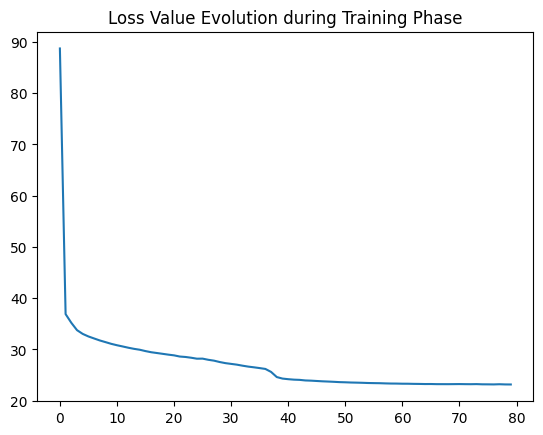

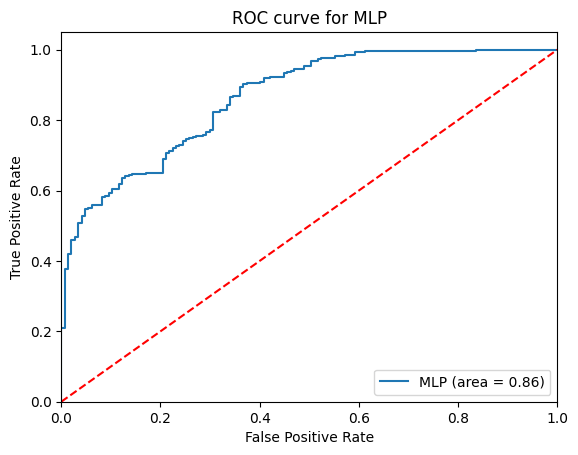

MLP roc_auc: 0.8634
MLP sensitivity: 0.6576
MLP specificity: 0.7959
MLP MCC: 0.4018


In [ ]:
'''
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
'''
train_loader = DataLoader(MyDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(MyDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)
model = MLPClassifier()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

epoch_losses = []
model.train()
for epoch in range(1, EPOCH_NUM+1):
    epoch_loss = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs.flatten(), labels.float())
        optimizer.zero_grad()
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_losses.append(epoch_loss)
    '''
    if epoch % SAVE_EVERY_EPOCHs==0:
        checkpoint_filename = os.path.join(checkpoint_dir, f'model_checkpoint_epoch{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch_loss': epoch_losses
        }, checkpoint_filename)
    '''
plt.plot(list(range(len(epoch_losses))), epoch_losses)
plt.title(f"Loss Value Evolution during Training Phase")
plt.show()

model.eval()
y_prob = []
with torch.no_grad():
    for inputs, labels in test_loader:
        y_prob += model(inputs).flatten().tolist()

fpr3, tpr3, thresholds = roc_curve(y_test, y_prob)
roc_auc3 = auc(fpr3, tpr3)

# Plot ROC curve
plt.plot(fpr3, tpr3, label=f'MLP (area = {roc_auc3:.2f})')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for MLP')
plt.legend(loc="lower right")
plt.show()
# Convert probabilities to binary predictions
y_pred = [1 if p >= 0.5 else 0 for p in y_prob]

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Sensitivity (or Recall or True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (or True Negative Rate)
specificity = tn / (tn + fp)

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)

# Print the values
print(f"MLP roc_auc: {roc_auc3:.4f}")
print(f"MLP sensitivity: {sensitivity:.4f}")
print(f"MLP specificity: {specificity:.4f}")
print(f"MLP MCC: {mcc:.4f}")


## Final Comparison (just adding confusion matrix on test set)

### Perform K-fold Cross Validation and examine the models

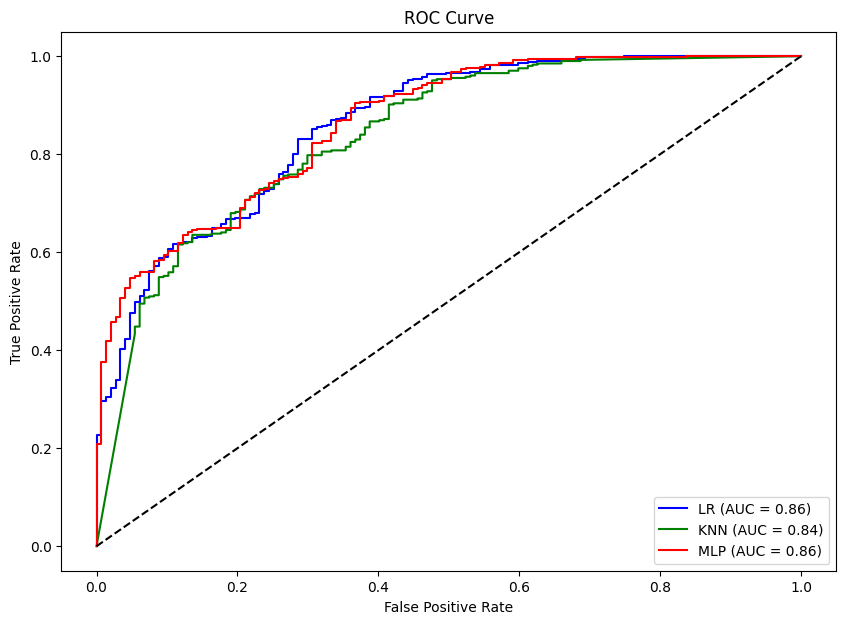

In [ ]:
plt.figure(figsize=(10, 7))

# Plot the ROC curve for the first model
plt.plot(fpr1, tpr1, color='blue', label=f'LR (AUC = {roc_auc1:.2f})')

# Plot the ROC curve for the second model
plt.plot(fpr2, tpr2, color='green', label=f'KNN (AUC = {roc_auc2:.2f})')

# Plot the ROC curve for the third model
plt.plot(fpr3, tpr3, color='red', label=f'MLP (AUC = {roc_auc3:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Set axis labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()


**Based on the result, MLP will be the best model in this case.**

### Perform prediction/classification using logistic regression model

ROC_AUC of logistic regression classifier on test set: 0.8599


              precision    recall  f1-score   support

           0       0.53      0.73      0.62       147
           1       0.89      0.76      0.82       406

    accuracy                           0.76       553
   macro avg       0.71      0.75      0.72       553
weighted avg       0.79      0.76      0.77       553



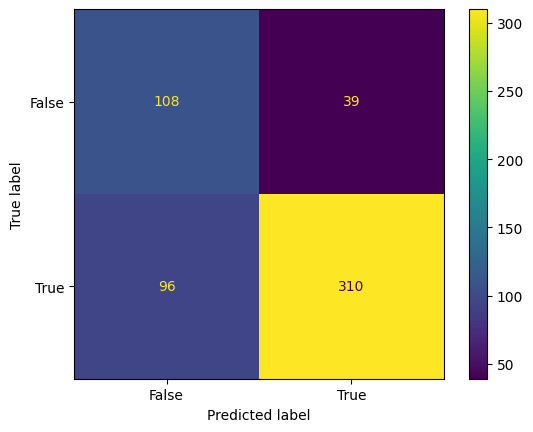

In [ ]:
from sklearn import metrics

# initialize model
LR_model = LogisticRegression(solver = 'liblinear')

# train the model using all training data
LR_model.fit(X_train, y_train)
y_pred_prob = lr.predict_proba(X_test)[:, 1]
# testing the model of
y_pred = LR_model.predict(X_test)

# evaluation of logistic regression model
roc_auc_lr = roc_auc_score(y_test, y_pred_prob)
print('ROC_AUC of logistic regression classifier on test set: {:.4f}'.format(roc_auc_lr))
print('\n')

# check confusion matrix
y_test_array = y_test.values
conf_matrix = confusion_matrix(y_test_array, y_pred)

print(classification_report(y_test, y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### Perform prediction/classification using KNN model

ROC_AUC of KNN classifier on test set: 0.8387
              precision    recall  f1-score   support

           0       0.56      0.64      0.59       147
           1       0.86      0.82      0.84       406

    accuracy                           0.77       553
   macro avg       0.71      0.73      0.72       553
weighted avg       0.78      0.77      0.77       553



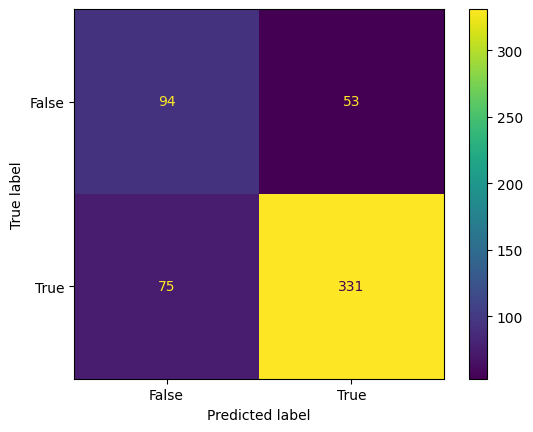

In [ ]:
# initialize model
knn_model = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='l1')

# train the model using all training data
knn_model.fit(X_train_scaled, y_train)

# testing the model of
y_pred_prob = knn.predict_proba(X_test_scaled)[:, 1]
y_pred = knn_model.predict(X_test_scaled)

# evaluation of logistic regression model
roc_auc_knn = roc_auc_score(y_test, y_pred_prob)
print('ROC_AUC of KNN classifier on test set: {:.4f}'.format(roc_auc_knn))

# check confusion matrix
y_test_array = y_test.values
conf_matrix = confusion_matrix(y_test_array, y_pred)

print(classification_report(y_test, y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### Perform prediction/classification using MLP model

ROC_AUC of MLP classifier on test set: 0.8634


              precision    recall  f1-score   support

           0       0.50      0.78      0.61       147
           1       0.90      0.71      0.80       406

    accuracy                           0.73       553
   macro avg       0.70      0.75      0.70       553
weighted avg       0.79      0.73      0.75       553



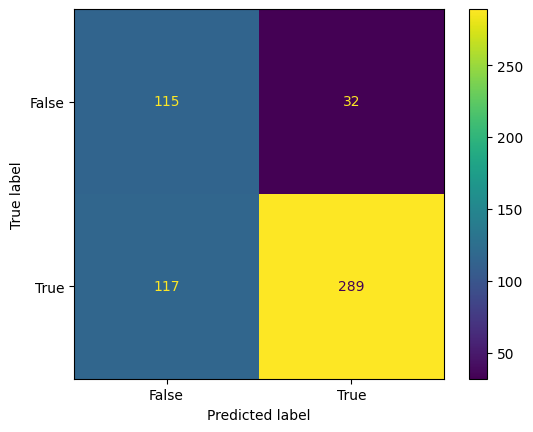

In [ ]:
# Predict on the test data
model.eval()

y_prob = []
with torch.no_grad():
    for inputs, labels in test_loader:
        y_prob += model(inputs).flatten().tolist()

# Evaluate the MLP model
#roc_auc_mlp = roc_auc_score(y_test, y_prob)
fpr3, tpr3, thresholds = roc_curve(y_test, y_prob)
roc_auc3 = auc(fpr3, tpr3)
print('ROC_AUC of MLP classifier on test set: {:.4f}'.format(roc_auc3))
print('\n')

# Confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
print(classification_report(y_test, y_pred_mlp))

cm_display_mlp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix_mlp, display_labels=[False, True])
cm_display_mlp.plot()
plt.show()
